`Lab creado por Margarita Geleta para el curso Introducción a Machine Learning JEDI, edición 2021`

# [X] Ensemble learning

En esta sesión conoceremos qué son los árboles de decision (*decision trees*) y los bosques aleatorios (*random forest*). Estos últimos son los que forman parte realmente de *ensemble learning*. Pues ... 

#### ¿Qué es *ensemble learning*?

Los modelos ensemble en Machine Learning son los que combinan las decisiones no de uno sinó de MÚLTIPLES modelos con el fin de mejorar el rendimiento global. 

#### ¿Para qué ensemble learning?

- Cada modelo individual se puede considerar como un "experto local". Local - en el subconjunto de datos con los que los entrenamos (puntualmente). Cada "experto local" se entrena con un subconjunto diferente, y sus decisiones no tienen que ser necesariamente precisas. Lo que sí es preciso es la combinación de sus decisiones "locales". Es importante que sus decisiones sean independientes!
- Se puede comparar con "divide-and-conquer", donde partimos un problema en varios subproblemas que se van resolviendo uno a uno y luego se combinan. Pues aquí partimos los datos en subconjuntos, en cada subconjunto se toma una decisión "local" y luego se van combinando para llegar a una decisión "global".

#### ¿Cuándo usar ensemble learning?

Cuando los expertos locales son independientes y devuelven un resultado no aleatorio. 

- Si su respuesta es aleatoria, no tiene sentido tener en cuenta su decisión ya que no está respaldada por nada. 
- Si los expertos locales no son independientes, tomarán la misma decisión. Entonces, ¿para qué mantener a muchos expertos si la decisión será la misma al final? Con uno ya tendríamos suficiente. Aunque parezca contradictorio, queremos que los "expertos locales" discrepen.

#### ¿Cómo combinar las decisiones?

- **Regresión**: media aritmética.
- **Clasificación**: mayoría.

---

## Árboles de decisión 
#### (*no es un modelo de ensemble learning!*)

Un árbol de decisión es un modelo de predicción que predice las variables target a partir de preguntas sobre variables.

- En un árbol un nodo es una pregunta sobre una variable.
- Tenemos que decidir de manera óptima cómo escoger las preguntas para hacer la partición óptima (que discrime mejor las etiquetas).

i.e.

- ¿Sobre qué variable preguntamos?
- Y ¿qué preguntamos?

Hay diferentes criterios:

- Gini impurity.
- Information gain: basado en entropía. 

Ejemplo a mano: 
https://www.academia.edu/7032069/An_example_of_calculating_gini_gain_in_CART

#### Clasificación

In [45]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn import tree

arbol = tree.DecisionTreeClassifier(random_state = 123)
iris = load_iris()

X = iris.data
Y = iris.target

scores = cross_val_score(arbol, X, Y, cv = 5,  scoring = 'accuracy')
print(scores.mean() * 100)
print(scores.std())

96.00000000000001
0.03265986323710903


100.0
95.0


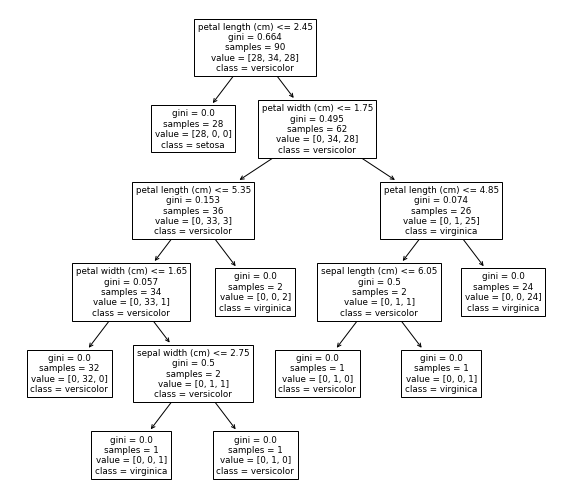

In [46]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4, random_state = 123)
modelo = tree.DecisionTreeClassifier()
modelo.fit(X_train, Y_train)
print(metrics.accuracy_score(Y_train, modelo.predict(X_train)) * 100)
print(metrics.accuracy_score(Y_test, modelo.predict(X_test)) * 100)

fig, ax = plt.subplots(1, 1, figsize = (10, 9))
tree.plot_tree(modelo, 
               impurity = True,
               class_names = iris.target_names,
               feature_names = iris.feature_names
              );

95.55555555555556
96.66666666666667


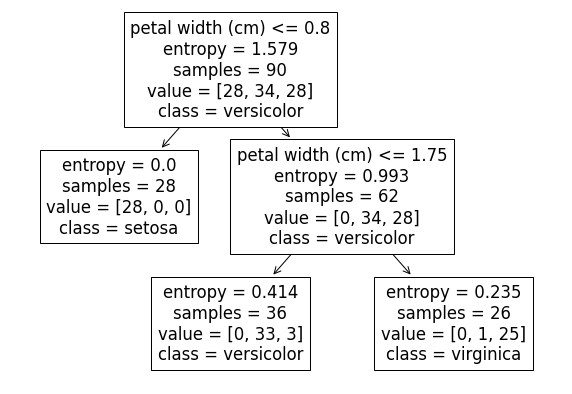

In [47]:
modelo = tree.DecisionTreeClassifier(criterion = 'entropy',
                                     max_depth = 2) # 2 preguntas
modelo.fit(X_train, Y_train)
print(metrics.accuracy_score(Y_train, modelo.predict(X_train)) * 100)
print(metrics.accuracy_score(Y_test, modelo.predict(X_test)) * 100)

fig, ax = plt.subplots(1, 1, figsize = (10, 7))
tree.plot_tree(modelo, 
               impurity = True,
               class_names = iris.target_names,
               feature_names = iris.feature_names
              );

In [51]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    #print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [52]:
tree_to_code(modelo, iris.feature_names)

  if petal width (cm) <= 0.800000011920929:
    return [[28.  0.  0.]]
  else:  # if petal width (cm) > 0.800000011920929
    if petal width (cm) <= 1.75:
      return [[ 0. 33.  3.]]
    else:  # if petal width (cm) > 1.75
      return [[ 0.  1. 25.]]


#### Regresión

In [53]:
from sklearn.datasets import load_boston
from sklearn.tree import DecisionTreeRegressor

X, Y = load_boston(return_X_y = True)
regressor = DecisionTreeRegressor(random_state = 123)

scores = cross_val_score(regressor, X, Y, cv = 5)
print(scores.mean() * 100)
print(scores.std())

9.698622652601072
0.9482218718135335


---

## Bosques aleatorios 
#### (Random Forest) - es un modelo de ensemble learning!

Un árbol de decisión, ok. *¿Pero un conjunto de árboles de decisión ... ?* **Sí, ensemble learning se basa en eso.** Hipótesis: trabajando en equipo, llegaremos a un error de predicción menor.

*Ejemplo* (regresión): desigualdad de Cauchy:
$$
\left(\frac{1}{L} \sum_{i=1}^L \epsilon_i\right)^2 = \frac{1}{L}\sum_{i=1}^L \epsilon_i^2
$$

**Cada árbol se entrena con un train test diferente independiente.** Así, tendremos $K$ árboles de decisión que formarán el bosque.

> ¿Por qué *aleatorio*? **Por dos cosas !**

- **La primera**: para independizar más a los árboles de decisión, queremos que hagan preguntas diferentes. Añadimos cierta aleatoriedad a los criterios. Coger un subset de $m$ variables (de un total de $p$).
- **La segunda**: solo tenemos un train set. ¿Cómo de este podemos crear $N$ train sets “bastante” independientes?

Una buena técnica es el **BOOTSTRAPPING**.





#### Bootstrapping + Bagging

Se trata de muestrear una muestra… para obtener $K$ submuestras de tamaño $N$ (el tamaño de la muestra original).
<div style="display:flex; justify-content: center;">
    <img src="data/bootstrap1.png" alt="drawing" style="height:300px;"/>
</div>

Entrenamos $K$ árboles con estas $K$ submuestras → ya tenemos un bosque. Esto se llama *Bagging*.
<div style="display:flex; justify-content: center;">
    <img src="data/bootstrap2.png" alt="drawing" style="height:300px;"/>
</div>

Para escoger el subset de variables en cada modelo hay varias heurísticas:

- Para clasificación: `m = sqrt(p)`
- Para regresión: `m = p / 3`

<div style="display:flex; justify-content: center;">
    <img src="data/bootstrap3.png" alt="drawing" style="height:300px;"/>
</div>

#### ¿Cuántos árboles hay que *plantar* en un bosque?

Si ponemos demasiados, podemos llegar a overfitting. Una buena medida es el **OOB (Out-of-Bag Error)**: no necesitamos un test set ya que OOB utiliza las observaciones que no utilizamos en las submuestras (que aprox es 1/3) y hace una buena estimación del error de test.
<div style="display:flex; justify-content: center;">
    <img src="data/bootstrap4.png" alt="drawing" style="height:300px;"/>
    <img src="data/bootstrap5.png" alt="drawing" style="height:300px;"/>
</div>


---
#### Clasificación

In [54]:
from sklearn.ensemble import RandomForestClassifier

bosque = RandomForestClassifier(n_estimators = 100,
                                criterion = 'gini',
                                max_depth = None,
                                max_features = 'sqrt',
                                oob_score = True,
                                random_state = 123)

iris = load_iris()
X = iris.data
Y = iris.target

bosque.fit(X, Y)
print(bosque.feature_importances_)
print(iris.feature_names)
print('OOB error: {}'.format(1 - bosque.oob_score_))

[0.08738947 0.0257446  0.4611169  0.42574903]
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
OOB error: 0.046666666666666634


In [55]:
RANDOM_STATE = 123
ensembles = [
    ("RandomForestClassifier, max_features = 'sqrt'",
        RandomForestClassifier(oob_score = True,
                               max_features = "sqrt",
                               random_state = RANDOM_STATE)),
    ("RandomForestClassifier, max_features = 'log2'",
        RandomForestClassifier(max_features = 'log2',
                               oob_score = True,
                               random_state = RANDOM_STATE)),
    ("RandomForestClassifier, max_features = None",
        RandomForestClassifier(max_features = None,
                               oob_score = True,
                               random_state = RANDOM_STATE))
]

In [56]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import make_classification

error_rate = {}

X, Y = make_classification(n_samples = 500, n_features = 25,
                           n_clusters_per_class = 1, n_informative = 15,
                           random_state = RANDOM_STATE)

for nombre, modelo in ensembles:
    error_rate[nombre] = []
    for i in range(15, 175 + 1):
        modelo.set_params(n_estimators = i)
        modelo.fit(X, Y)

        oob_error = 1 - modelo.oob_score_
        error_rate[nombre].append(oob_error)
    print(nombre + ' trained')


RandomForestClassifier, max_features = 'sqrt' trained
RandomForestClassifier, max_features = 'log2' trained
RandomForestClassifier, max_features = None trained


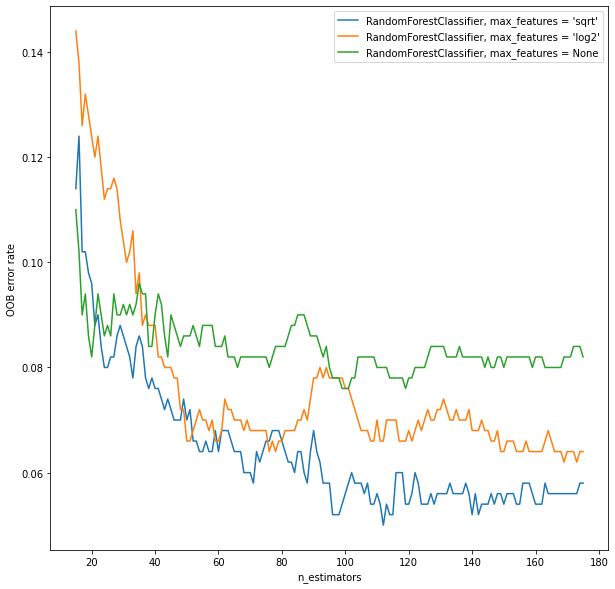

In [57]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

for modelo, error in error_rate.items():

    ax.plot(range(15, 175 + 1), error, label = modelo)

plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc = "upper right")
plt.show()

#### Regresión

In [58]:
from sklearn.ensemble import RandomForestRegressor

X, Y = load_boston(return_X_y = True)
bosque = RandomForestRegressor(n_estimators = 100,
                                criterion = 'mse',
                                max_depth = None,
                                max_features = 'sqrt',
                                oob_score = True,
                                random_state = 123)

bosque.fit(X, Y)
print(bosque.feature_importances_)
print(load_boston().feature_names)
print('OOB error: {}'.format(1 - bosque.oob_score_))

[0.06690625 0.01588984 0.06431204 0.00790072 0.06634841 0.28339401
 0.03597716 0.06610812 0.01864846 0.02821141 0.07438071 0.02522501
 0.24669786]
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
OOB error: 0.12985153942517302


In [59]:
print('Variables ordenadas según su importancia:')
print(sorted(zip(map(lambda x: round(x, 4), bosque.feature_importances_), load_boston().feature_names), 
             reverse = True))

Variables ordenadas según su importancia:
[(0.2834, 'RM'), (0.2467, 'LSTAT'), (0.0744, 'PTRATIO'), (0.0669, 'CRIM'), (0.0663, 'NOX'), (0.0661, 'DIS'), (0.0643, 'INDUS'), (0.036, 'AGE'), (0.0282, 'TAX'), (0.0252, 'B'), (0.0186, 'RAD'), (0.0159, 'ZN'), (0.0079, 'CHAS')]


In [60]:
load_boston().feature_names[np.argsort(importances)[::-1]]

NameError: name 'np' is not defined

In [ ]:
list(range(X.shape[1])),importances[indices]

In [ ]:
import numpy as np
importances = bosque.feature_importances_
std = np.std([arbol.feature_importances_ for arbol in bosque.estimators_],
             axis = 0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, load_boston().feature_names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize = (15, 5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color = "r", yerr = std[indices], align = "center")
plt.xticks(range(X.shape[1]), load_boston().feature_names[indices])
plt.xlim([-1, X.shape[1]])
plt.show()

---

## A practicar ...

Usemos el dataset de las encuestas para hacer clasificación (chico/chica), primero con un árbol de decisión y luego con un bosque aleatorio. Determina las variables más importantes según Random Forest.

In [ ]:
import pandas as pd
df = pd.read_csv('data/responses.csv').dropna()
Xmusic = df.iloc[:,2:19]
Xmovies = df.iloc[:,20:31]
Xsubjects = df.iloc[:,32:63]
Xphobias = df.iloc[:,64:73]
X = pd.concat([Xmusic, Xmovies, Xsubjects, Xphobias], axis = 1, sort = False)
Y = df['Gender']
X.head()

In [ ]:
X.shape

---

In [ ]:

arbol = tree.DecisionTreeClassifier(criterion = 'entropy',max_depth = None,random_state = 123)

scores = cross_val_score(arbol, X, Y, cv = 5,  scoring = 'accuracy')
print(scores.mean() * 100)
print(scores.std())

In [ ]:
#Variables para entrenar
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.4, random_state = 123)
#Llamamos nuestro modelo a entrenar
modelo = tree.DecisionTreeClassifier(max_depth = 2)
modelo.fit(X_train, Y_train)
#Imprimimos las metricas del train y del test
#Ingresamos los datos a entrenar
print(metrics.accuracy_score(Y_train, modelo.predict(X_train)) * 100)
print(metrics.accuracy_score(Y_test, modelo.predict(X_test))*100)

#Graficamos nuestro tree
fig, ax = plt.subplots(1,1, figsize = (20,10))
tree.plot_tree(modelo,
              impurity = True,
              feature_names = X.columns,
              class_names= Y.unique()
              );

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.4, random_state = 123)
modelo = tree.DecisionTreeClassifier(max_depth = 4)
modelo.fit(X_train, Y_train)

print(metrics.accuracy_score(Y_train, modelo.predict(X_train))*100)
print(metrics.accuracy_score(Y_test, modelo.predict(X_test))*100)

fig, ax = plt.subplots(1, 1, figsize = (20, 10))
tree.plot_tree(modelo, 
               impurity = True,
               feature_names = X.columns,
               class_names = Y.unique()
              );

In [ ]:
tree_to_code(modelo, X.columns)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4, random_state = 123)
modelo = tree.DecisionTreeClassifier(max_depth = None)
modelo.fit(X_train, Y_train)

print(metrics.accuracy_score(Y_train, modelo.predict(X_train))*100)
print(metrics.accuracy_score(Y_test, modelo.predict(X_test))*100)

fig, ax = plt.subplots(1, 1, figsize = (20, 10))
tree.plot_tree(modelo, 
               impurity = True,
               feature_names = X.columns,
               class_names = Y.unique()
              );

In [ ]:
bosque = RandomForestClassifier(n_estimators = 100,
                                criterion = 'gini',
                                max_depth = None,
                                max_features = 'sqrt',
                                oob_score = True,
                                random_state = 123)
bosque.fit(X,Y)
print('00B error:{}'.format(1 - bosque.oob_score_))
print()

print('Variables ordenadas según su importancia:')
print(sorted(zip(map(lambda x: round(x,4), bosque.feature_importances_),X.columns),reverse = True))

In [ ]:
importances = bosque.feature_importances_
std = np.std([arbol.feature_importances_ for arbol in bosque.estimators_],
             axis = 0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize = (15, 5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color = "r", yerr = std[indices], align = "center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90)
plt.xlim([-1, X.shape[1]])
plt.show()
